In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab
import os
import random
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn

## 1. Dataset Overview

In [7]:
directories = {
    "Train Cat": "datasets/train/cat",
    "Train Dog": "datasets/train/dog",
    "Val Cat": "datasets/val/cat",
    "Val Dog": "datasets/val/dog"
}

In [8]:
def count_samples(dir):
    return len(os.listdir(dir))

In [9]:
# Apply the function to all directories and store results in a dictionary
sample_counts = {name: count_samples(path) for name, path in directories.items()}

# Display the sample counts for each directory
print(sample_counts)

{'Train Cat': 10000, 'Train Dog': 10000, 'Val Cat': 2500, 'Val Dog': 2500}


## 2. Image Properties

In [8]:
def get_dims(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size[1], img.size[0]  # (height, width)
    except Exception as e:
        return None, None

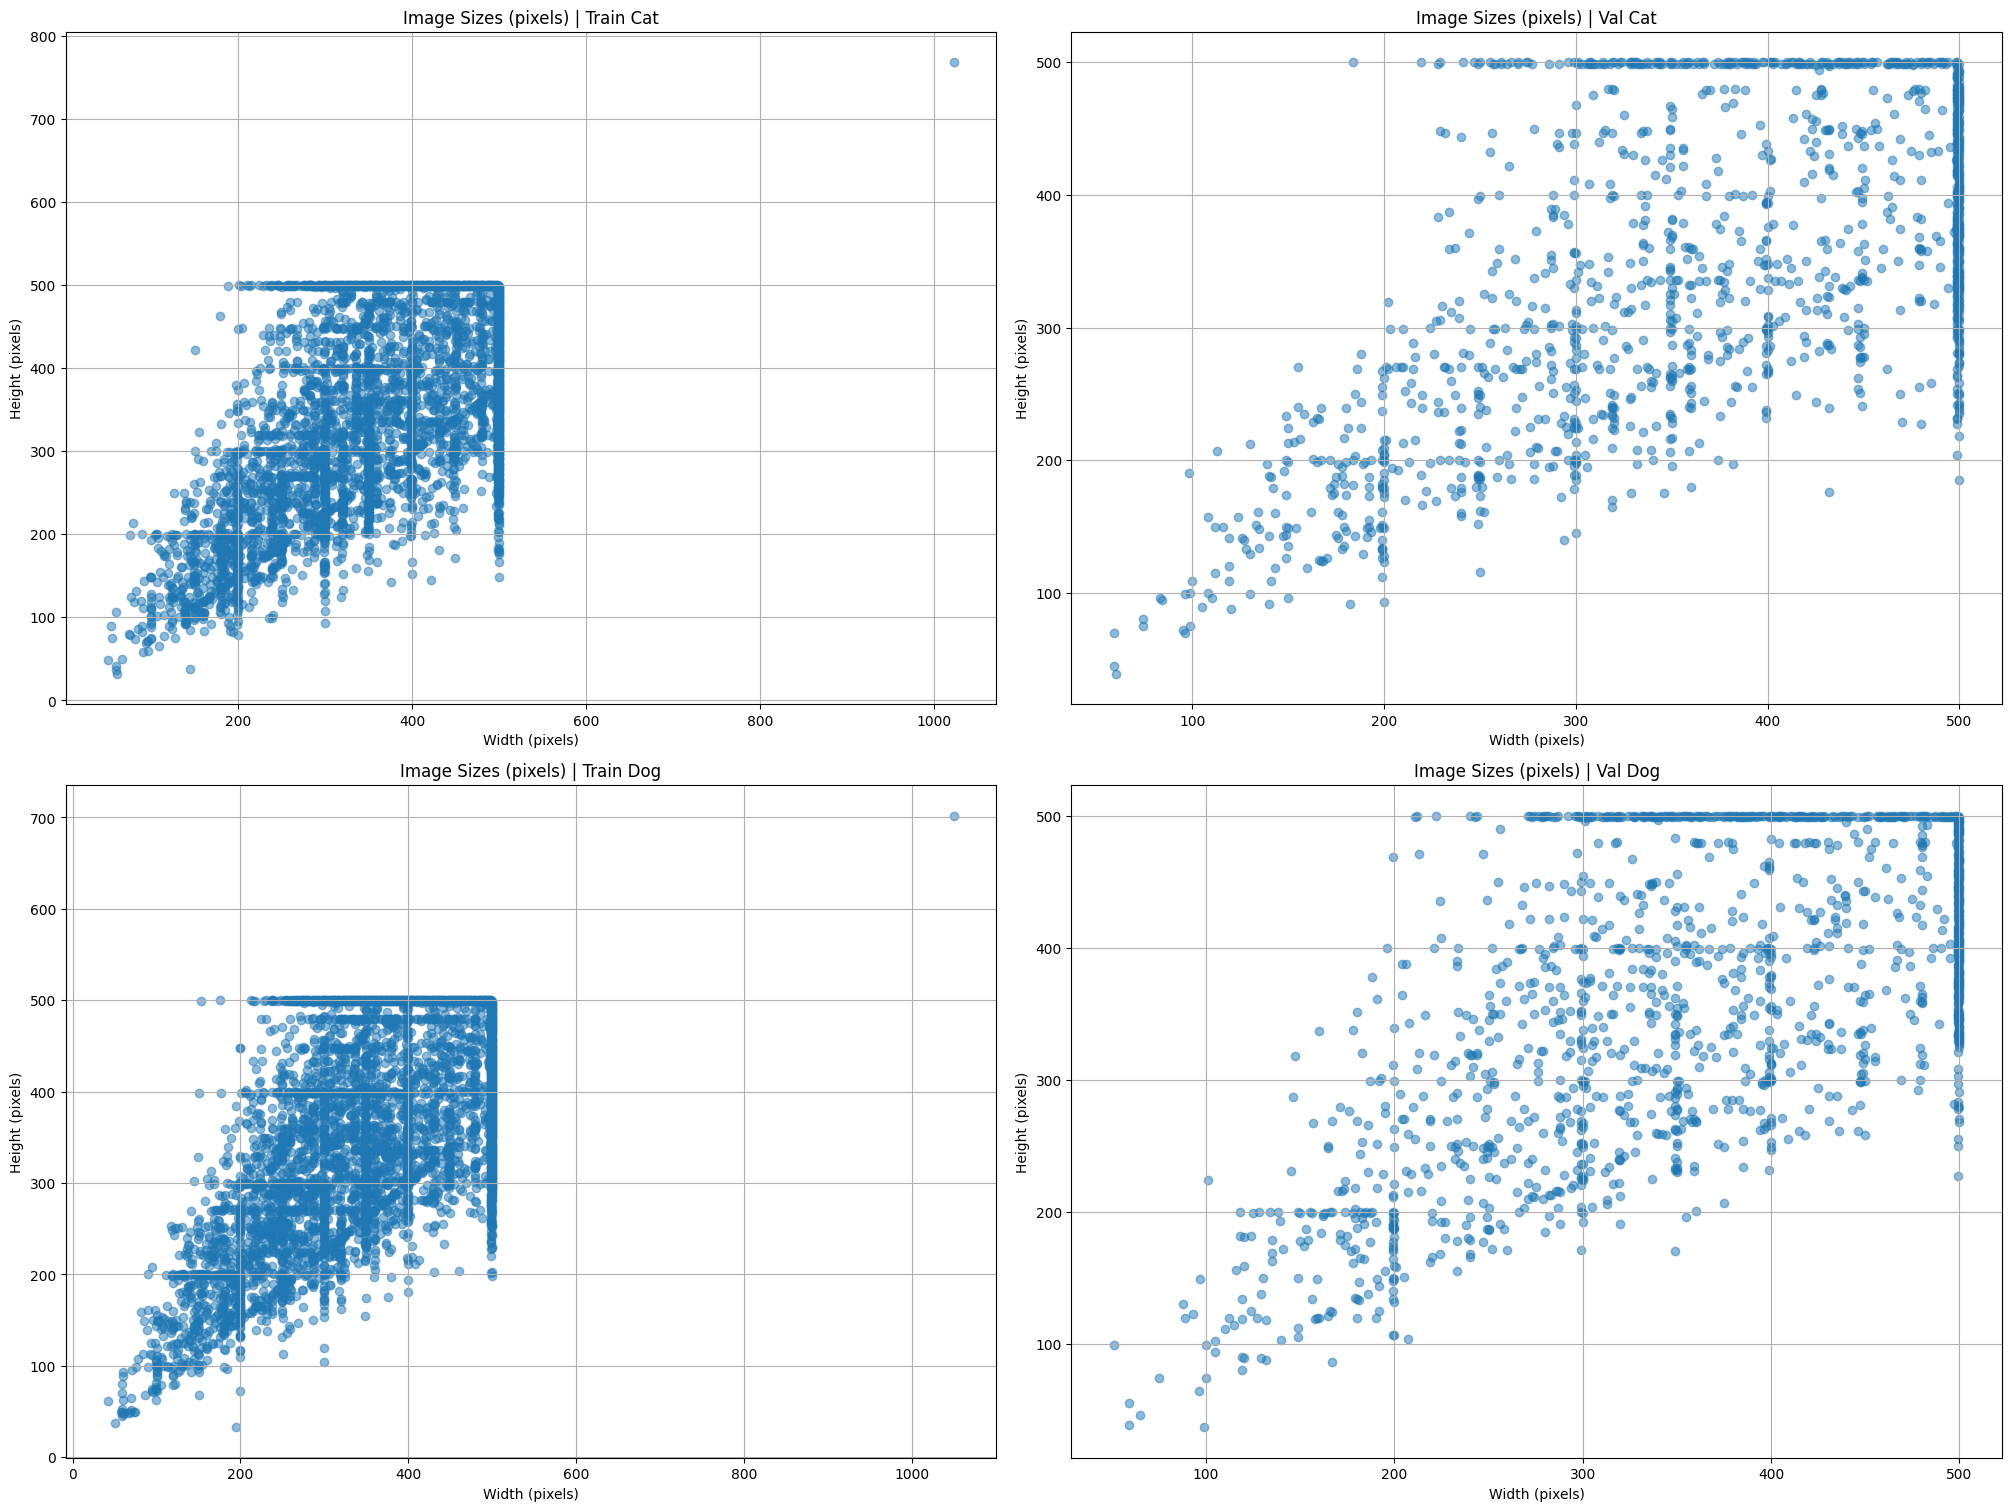

In [9]:
from matplotlib.gridspec import GridSpec

# Creating and preparing figure and axis for 4 graphs
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = GridSpec(2, 2, figure=fig)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]

# Loop through directories to gather and plot image size data
for ax, (n, d) in zip(axes, directories.items()):
    filepath = d
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, f))]
    
    dims = [get_dims(file) for file in filelist]
    
    # Filter out any None values that indicate failed image loading
    dims = [dim for dim in dims if dim != (None, None)]
    
    # Create a DataFrame and plot the scatter of image sizes
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0: 'count'})
    
    ax.scatter(sizes['width'], sizes['height'], alpha=0.5)
    ax.set_title(f'Image Sizes (pixels) | {n}')
    ax.set_xlabel('Width (pixels)')
    ax.set_ylabel('Height (pixels)')
    ax.grid(True)

# Show the combined plot
plt.show()

In [26]:
def find_large_images(directory, threshold=1000):
    large_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    if width >= threshold or height >= threshold:
                        large_images.append((file_path, width, height))
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return large_images

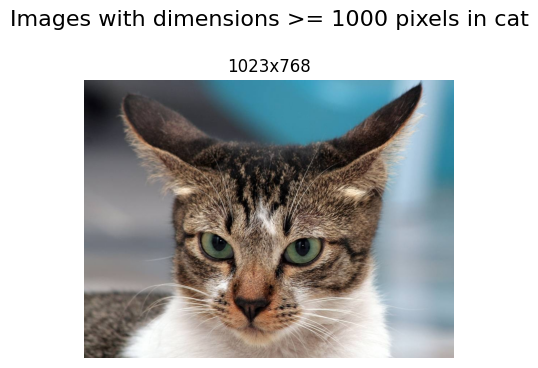

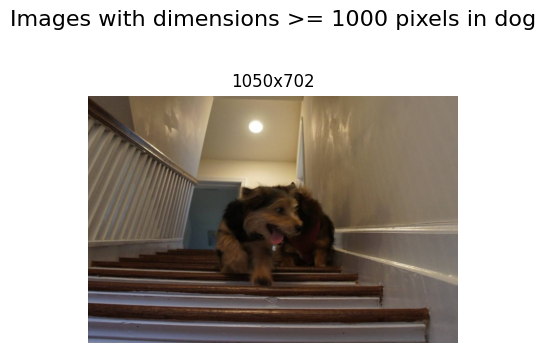

In [27]:

def display_large_images(directory, threshold=1000):
    large_images = find_large_images(directory, threshold)
    
    if not large_images:
        print(f"No images found with dimensions >= {threshold} pixels in {directory}")
        return
    
    num_images = len(large_images)
    cols = min(num_images, 5)  # Display up to 5 images per row
    rows = (num_images - 1) // cols + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    fig.suptitle(f'Images with dimensions >= {threshold} pixels in {os.path.basename(directory)}', fontsize=16)
    
    # Ensure axes is always an array for consistent indexing
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = np.array(axes).reshape(-1)
    
    for i, (file_path, width, height) in enumerate(large_images):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        img = Image.open(file_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{width}x{height}')
    
    # Hide any unused subplots
    for i in range(num_images, rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display large images for Train Cat and Train Dog
display_large_images(directories["Train Cat"])
display_large_images(directories["Train Dog"])

## 3. Visual Inspection

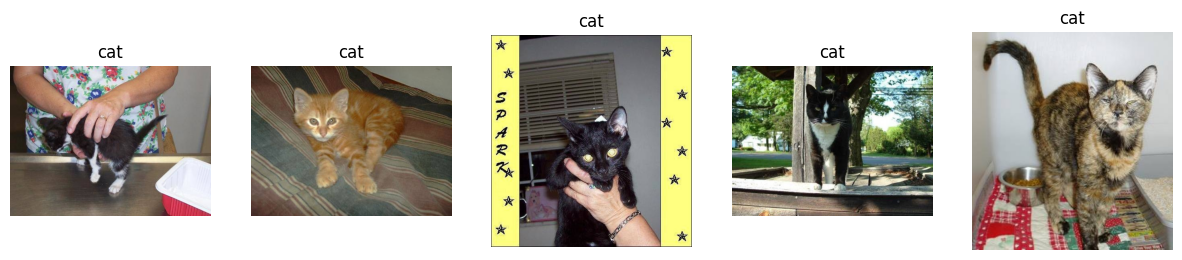

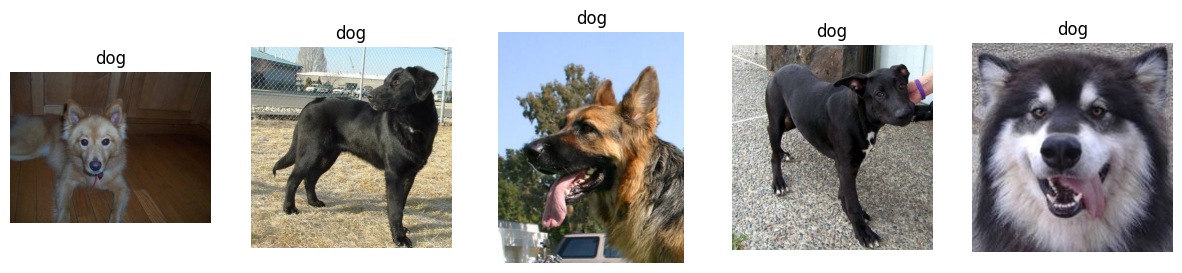

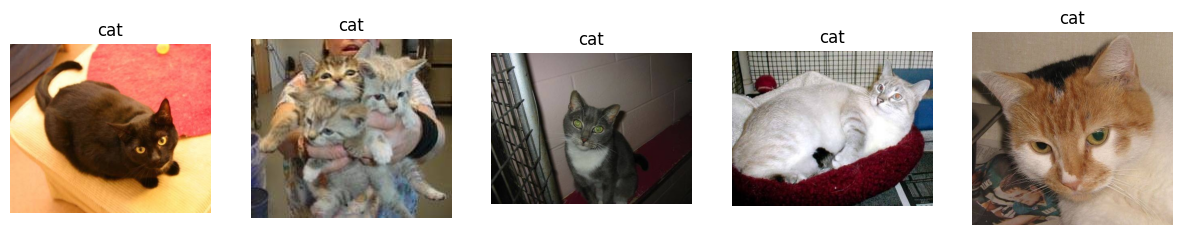

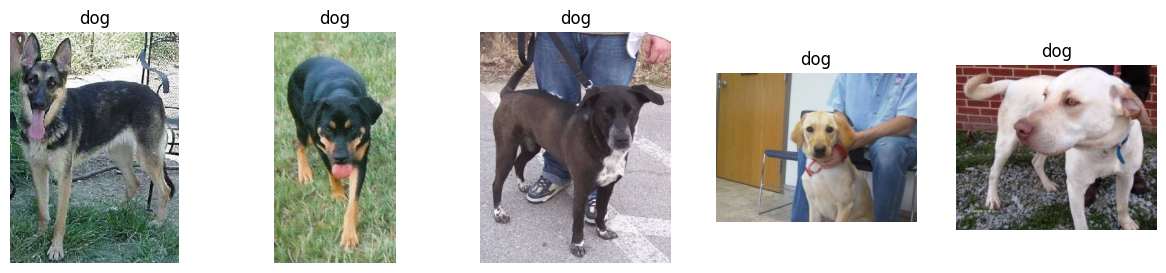

{'Train Cat': None, 'Train Dog': None, 'Val Cat': None, 'Val Dog': None}

In [11]:
def display_random_images(directory, num_images=5):
    plt.figure(figsize=(15, 3))
    all_files = [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files]
    sampled_files = random.sample(all_files, num_images)
    
    for i, file_path in enumerate(sampled_files):
        img = Image.open(file_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(os.path.dirname(file_path)))
    plt.show()

display = {name: display_random_images(path) for name, path in directories.items()}
display

## 4. Image Corruption

In [10]:
# Function to check and remove corrupted images
def check_and_remove_corrupted_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the image file integrity
            print(f"Image is fine: {file_path}")  # Print the image path if it's not corrupted
        return False  # Image is not corrupted
    except (IOError, SyntaxError) as e:
        print(f"Removing corrupted image: {file_path} - {e}")  # Print the corrupted image path
        os.remove(file_path)  # Remove corrupted image file
        return True  # Image was corrupted and removed

# Function to scan and clean a directory
def scan_and_clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            check_and_remove_corrupted_image(file_path)

In [11]:
for directory in directories:
    scan_and_clean_directory(directory)

## 5. Normalize Image - Data Loader

In [12]:
train_directories = {
    "Train Cat": "vgg19/datasets/train/cat",
    "Train Dog": "vgg19/datasets/train/dog"
}

In [14]:
# 5. Image Statistics
def analyze_pixel_intensities(directory, sample_size=100):
    all_files = [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))
    
    intensities = []
    for file_path in sampled_files:
        img = Image.open(file_path).convert('L')  # Convert to grayscale
        intensities.extend(list(img.getdata()))
    
    plt.figure(figsize=(10, 5))
    plt.hist(intensities, bins=50)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()

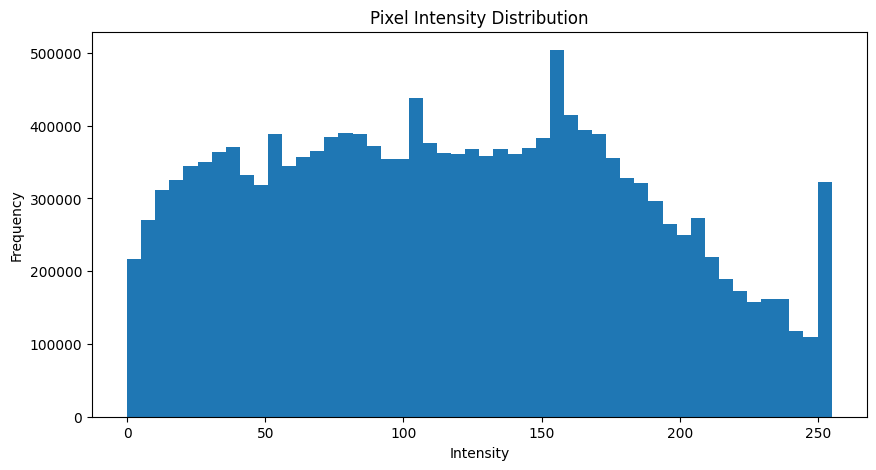

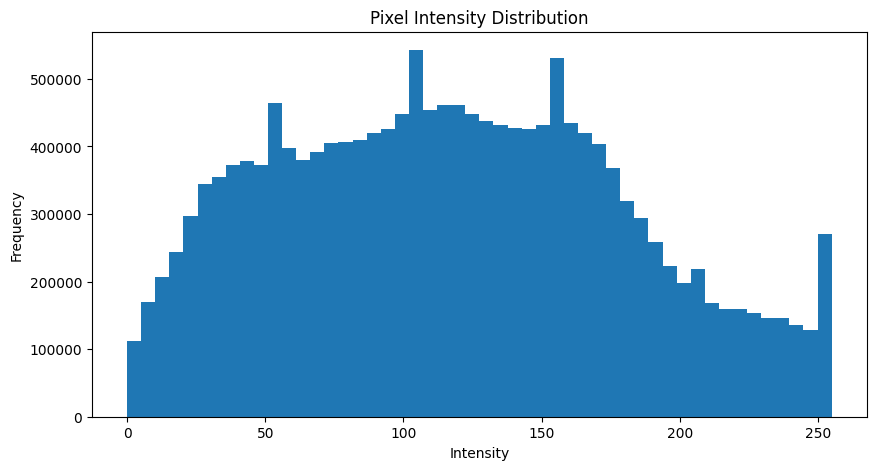

{'Train Cat': None, 'Train Dog': None}

In [16]:
pixel_original = {name: analyze_pixel_intensities(path) for name, path in train_directories.items()}
pixel_original

Range intensity from 0 to 255

Now we Transforming images to Tensors using torchvision.transforms.ToTensor()

In [17]:
# Transform to convert images to tensors
to_tensor = transforms.ToTensor()

pixel_values = []
# Initialize variables to accumulate sum and squared sum
sum_channels = torch.zeros(3)
sum_squared_channels = torch.zeros(3)
num_pixels = 0

# Iterate over train images to compute the mean and std
for n, d in train_directories.items():
    for file_name in os.listdir(d):
        file_path = os.path.join(d, file_name)
        if os.path.isfile(file_path):
            try:
                # Open image and convert to tensor
                with Image.open(file_path) as img:
                    img_tensor = to_tensor(img)
                    
                    # Accumulate sum of channels and squared sum
                    sum_channels += torch.sum(img_tensor, dim=(1, 2))
                    sum_squared_channels += torch.sum(img_tensor ** 2, dim=(1, 2))
                    
                    # Accumulate the number of pixels processed
                    num_pixels += img_tensor.shape[1] * img_tensor.shape[2]
                    # pixel_values.extend(img_tensor.numpy().ravel())
            except Exception as e:
                # Handle any issues with loading the image
                print(f"Error processing {file_path}: {e}")

# Calculate mean and standard deviation for each channel
mean = sum_channels / num_pixels
std = torch.sqrt(sum_squared_channels / num_pixels - mean ** 2)

print("Mean and std before normalization:")
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean and std before normalization:
Mean: tensor([0.4863, 0.4532, 0.4155])
Std: tensor([0.2621, 0.2557, 0.2582])


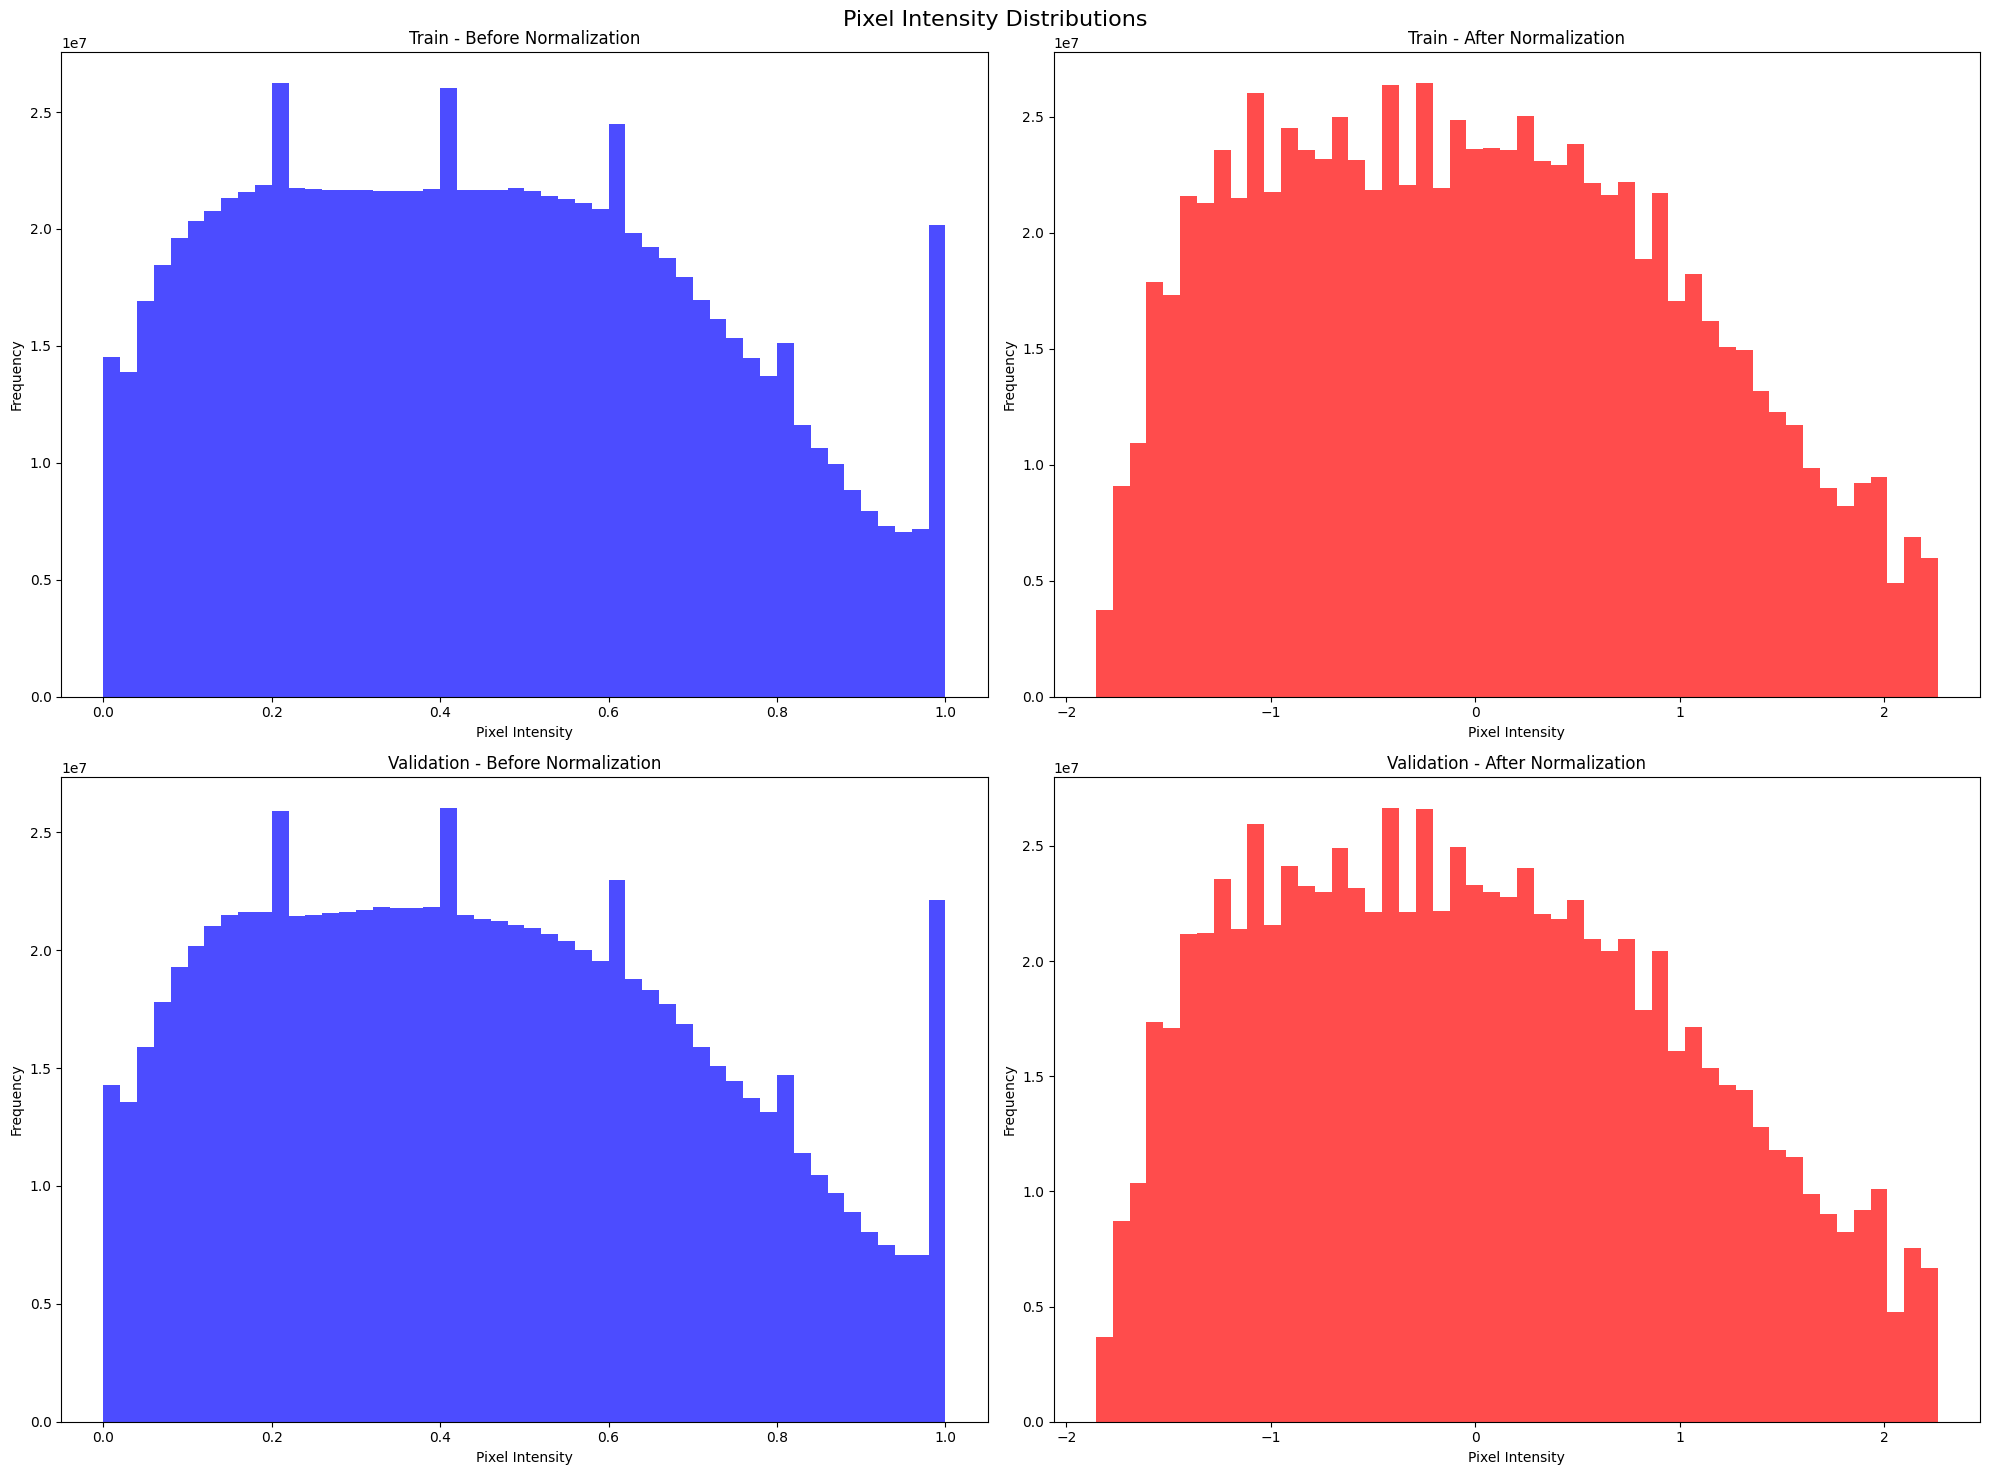


Train Dataset:
Before Normalization - Mean: 0.4523, Std: 0.2617
After Normalization - Mean: 0.0024, Std: 1.0064

Validation Dataset:
Before Normalization - Mean: 0.4512, Std: 0.2631
After Normalization - Mean: -0.0016, Std: 1.0112


In [18]:
# Convert mean and std tensors to lists for the normalization transform
mean = mean.tolist()
std = std.tolist()

# Define directories
directories = {
    "Train": "vgg19/datasets/train",
    "Validation": "vgg19/datasets/val"
}


# Define normalization transform
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Function to get pixel intensities
def get_pixel_intensities(directory, transform=None, num_images=1000):
    intensities = []
    for root, _, files in os.walk(directory):
        for file in files[:num_images]:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if transform:
                        img_tensor = transform(img)
                    else:
                        img_tensor = to_tensor(img)
                    intensities.append(img_tensor.numpy().flatten())
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return np.concatenate(intensities)
    
# Create subplots for pixel intensity distributions before and after normalization
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Pixel Intensity Distributions', fontsize=16)

for i, (name, directory) in enumerate(directories.items()):
    # Before normalization
    intensities = get_pixel_intensities(directory)
    axs[i, 0].hist(intensities, bins=50, range=(0, 1), color='blue', alpha=0.7)
    axs[i, 0].set_title(f'{name} - Before Normalization')
    axs[i, 0].set_xlabel('Pixel Intensity')
    axs[i, 0].set_ylabel('Frequency')

    # After normalization
    intensities_norm = get_pixel_intensities(directory, transform_norm)
    axs[i, 1].hist(intensities_norm, bins=50, color='red', alpha=0.7)
    axs[i, 1].set_title(f'{name} - After Normalization')
    axs[i, 1].set_xlabel('Pixel Intensity')
    axs[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics before and after normalization
for name, directory in directories.items():
    intensities = get_pixel_intensities(directory)
    intensities_norm = get_pixel_intensities(directory, transform_norm)
    
    print(f"\n{name} Dataset:")
    print(f"Before Normalization - Mean: {np.mean(intensities):.4f}, Std: {np.std(intensities):.4f}")
    print(f"After Normalization - Mean: {np.mean(intensities_norm):.4f}, Std: {np.std(intensities_norm):.4f}")

In [29]:
directories = {
    "Train": "vgg19/datasets/train",
    "Validation": "vgg19/datasets/val"
}

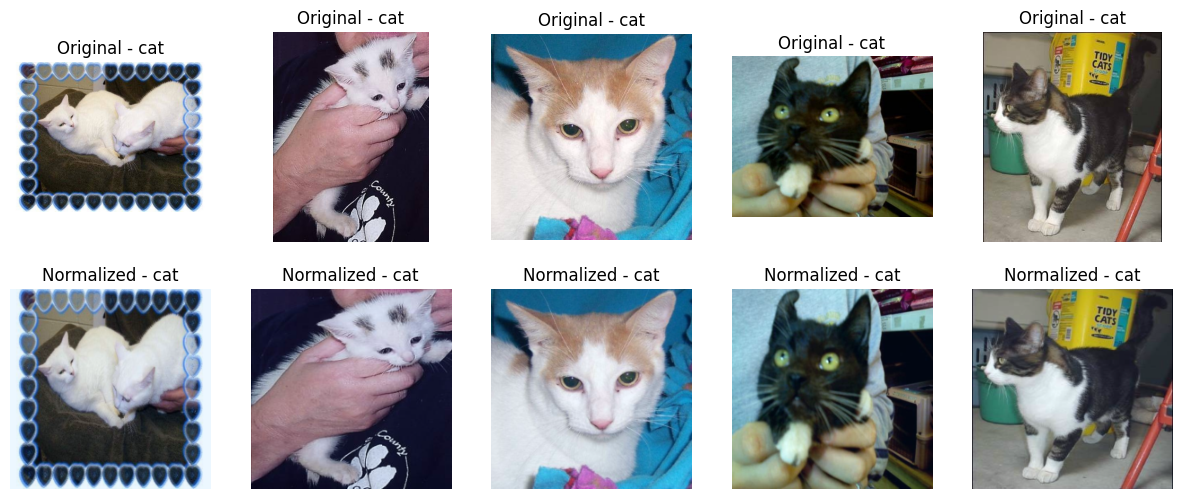

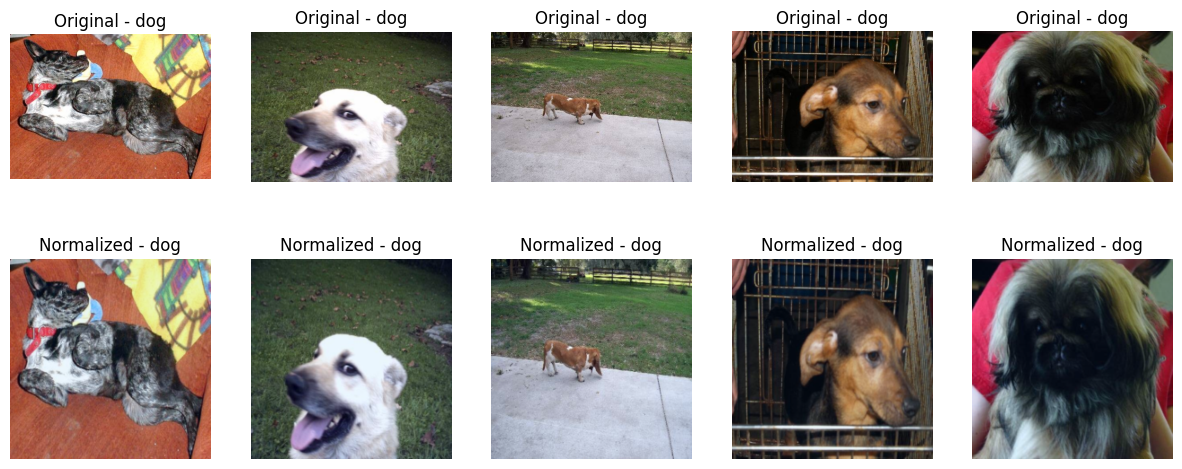

In [30]:
# Define normalization transform
transform_norm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Function to display random images (both original and normalized)
def display_random_images(directory, num_images=5):
    plt.figure(figsize=(15, 6))
    all_files = [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files]
    sampled_files = random.sample(all_files, num_images)
    
    for i, file_path in enumerate(sampled_files):
        img = Image.open(file_path)
        
        # Display Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Original - {os.path.basename(os.path.dirname(file_path))}")
        
        # Apply normalization
        img_tensor = transform_norm(img)
        
        # Convert normalized tensor to NumPy array and transpose for display
        # Transpose from shape of (3,,) to shape of (,,3)
        img_normalized = img_tensor.numpy().transpose(1, 2, 0)
        
        # Normalize the image to range [0, 1] for visualization (optional)
        img_normalized = (img_normalized - img_normalized.min()) / (img_normalized.max() - img_normalized.min())
        
        # Display Normalized Image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(img_normalized)
        plt.axis('off')
        plt.title(f"Normalized - {os.path.basename(os.path.dirname(file_path))}")
    
    plt.show()

# Display images for each dataset
display = {name: display_random_images(path) for name, path in directories.items()}
